In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,BaggingClassifier,StackingClassifier,VotingClassifier,HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from matplotlib import pyplot

# Importing the dataset
dataset = pd.read_csv('./data/train_50k.csv',delimiter =',')
dataset = dataset.drop(['PA'],axis=1)
print(dataset)

       CN        RA        JC         AA  Label
0      89  0.016363  0.020588  10.121960      1
1      14  0.004045  0.006890   1.607620      1
2       2  0.000003  0.000017   0.149925      1
3       0  0.000000  0.000000   0.000000      1
4       0  0.000000  0.000000   0.000000      1
...    ..       ...       ...        ...    ...
99995   0  0.000000  0.000000   0.000000      0
99996   0  0.000000  0.000000   0.000000      0
99997   0  0.000000  0.000000   0.000000      0
99998   0  0.000000  0.000000   0.000000      0
99999   0  0.000000  0.000000   0.000000      0

[100000 rows x 5 columns]


In [2]:
FEATURE_SIZE=4
X = dataset.iloc[:,0:FEATURE_SIZE].values
y = dataset.iloc[:, FEATURE_SIZE].values
X

array([[8.90000000e+01, 1.63630019e-02, 2.05875549e-02, 1.01219597e+01],
       [1.40000000e+01, 4.04548800e-03, 6.88976378e-03, 1.60762045e+00],
       [2.00000000e+00, 3.27318232e-06, 1.67571553e-05, 1.49924838e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [3]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
print(np.amin(x_test))

-0.16773780289600349


In [4]:
# self defined scorer function, using auc.
def scorer(estimator,X,y):
    pre = estimator.predict_proba(x_test)
    y_pre=[p[1] for p in pre]
    acc=estimator.score(x_test,y_test)
    auc=roc_auc_score(y_test,y_pre)
    print(estimator, auc,acc)
    #return acc
    return auc


In [ ]:
#test the different parameters of svm

from sklearn.model_selection import GridSearchCV as gsc
#parameters used 
parameters = {'kernel':('linear','poly', 'rbf', 'sigmoid'), 'C':[1,5,10]}
svc = SVC(probability=True)
clf = gsc(svc,parameters,n_jobs=-1,scoring=scorer, verbose=10)
clf.fit(x_train,y_train)
pre=clf.predict_proba(x_test)
#print out the best parameters
print(clf.best_params_)




Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [7]:
#test forest params using grid search
from sklearn.model_selection import GridSearchCV as gsc
parameters = {'n_estimators':[100,1000,10000],'min_samples_split':[2,4,6]}
rfc = RandomForestClassifier(n_estimators=1000, max_features="auto",random_state=0)
clf = gsc(rfc,parameters,n_jobs=-1,scoring=scorer, verbose=10)
clf.fit(x_train,y_train)
pre=clf.predict_proba(x_test)
#print out the best parameters
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 20.8min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 29.6min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 32.1min finished


{'min_samples_split': 6, 'n_estimators': 10000}


In [49]:
#training new features on best_params_
svc = SVC(kernel='linear',C=10,probability=True)
svc.fit(x_train,y_train)
pre=svc.predict_proba(x_test)
y_pre=[p[1] for p in pre]
acc=svc.score(x_test,y_test)
print(acc)
auc=roc_auc_score(y_test,y_pre)
print(auc)


0.89125
0.9002861661402214


In [5]:
#test params
svc = SVC(kernel='linear',C=10,probability=True)
ada=AdaBoostClassifier(svc,n_estimators=5)
ada.fit(x_train,y_train)
pre=ada.predict_proba(x_test)
y_pre=[p[1] for p in pre]
acc=ada.score(x_test,y_test)
print(acc)
auc=roc_auc_score(y_test,y_pre)
print(auc)

0.81335
0.8975497047993554


In [51]:
#get models for voting
def get_voting():
    models = list()
    svc = SVC(kernel='linear',C=10,probability=True)
    #models.append(('ada',AdaBoostClassifier(svc,n_estimators=4)))
    #models.append(('bc',BaggingClassifier(base_estimator=SVC(kernel='linear',C=10,probability=True),n_estimators=10, random_state=0)))
    models.append(('etc',ExtraTreesClassifier(n_estimators=1000, random_state=0)))
    models.append(('gbc',GradientBoostingClassifier(random_state=0)))
    models.append(('hgbc',HistGradientBoostingClassifier()))
    models.append(('rfc',RandomForestClassifier(n_estimators=1000, max_features="auto",random_state=0)))
    ensemble = VotingClassifier(estimators=models,voting = 'soft')
    return ensemble
    


In [52]:
#get models for individual testing
def get_models():
    models = dict() 
    svc = SVC(kernel='linear',C=10,probability=True)
    #models['ada'] = AdaBoostClassifier(svc,n_estimators=4)
    #models['bc'] = BaggingClassifier(base_estimator=SVC(kernel='linear',C=10,probability=True),n_estimators=10, random_state=0)
    models['etc'] = ExtraTreesClassifier(n_estimators=10000,min_samples_split=6, random_state=0)
    models['gbc'] = GradientBoostingClassifier(random_state=0)
    models['hgbc'] = HistGradientBoostingClassifier()
    models['rfc']  = RandomForestClassifier(n_estimators=10000,min_samples_split=6, max_features="auto",random_state=0)
    models['voting'] = get_voting()
    return models


In [53]:
#cross-validation testing on ensemble methods
def evaluate(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 0)
    results = cross_val_score(model,X,y,scoring=scorer,cv=cv,n_jobs=-1,error_score='raise', verbose=10)
    return results


In [ ]:
#main and print for acores
models = get_models()
results, names = list(), list()
for name, model in models.items():
    print(name)
    scores = evaluate(model,x_train,y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.4f (%.3f)' % (name, np.mean(scores), np.std(scores)))


    

etc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 24.2min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 24.6min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 30.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>etc 0.9009 (0.000)
gbc


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   24.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   28.5s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   31.3s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


>gbc 0.9016 (0.000)
hgbc


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    4.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    5.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    6.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.3s finished


>hgbc 0.9017 (0.000)
rfc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 12.1min


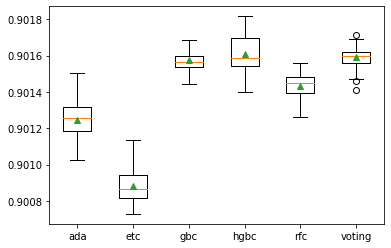

In [27]:
#plot
pyplot.boxplot(results,labels=names,showmeans=True)
pyplot.show()

In [28]:
'''
prob_predictions = [y_pre_ada,y_pre_rfc,y_pre_gbc,y_pre_bc,y_pre_etc,y_pre_hgbc]
ensemble_pred = [sum(x)/len(x) for x in zip(*prob_predictions)]
auc = roc_auc_score(y_test,ensemble_pred)
print(auc)
'''

'\nprob_predictions = [y_pre_ada,y_pre_rfc,y_pre_gbc,y_pre_bc,y_pre_etc,y_pre_hgbc]\nensemble_pred = [sum(x)/len(x) for x in zip(*prob_predictions)]\nauc = roc_auc_score(y_test,ensemble_pred)\nprint(auc)\n'

In [29]:
#train the ensemble methods via voting and validate
ensemble = get_voting()
ensemble.fit(x_train,y_train)
pre = ensemble.predict_proba(x_test)
y_pre=[p[1] for p in pre]
acc=ensemble.score(x_test,y_test)
auc=roc_auc_score(y_test,y_pre)
print(ensemble, auc,acc)


VotingClassifier(estimators=[('ada', AdaBoostClassifier(n_estimators=1000)),
                             ('etc',
                              ExtraTreesClassifier(n_estimators=1000,
                                                   random_state=0)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=0)),
                             ('hgbc', HistGradientBoostingClassifier()),
                             ('rfc',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=0))],
                 voting='soft') 0.9015960617820703 0.89335


In [30]:
#perform final test on kaggle data
testdata = pd.read_csv('./data/test_50k.csv')
x_testing = testdata.iloc[:,0:FEATURE_SIZE].values 
x_testing = sc.transform(x_testing)
predictions=ensemble.predict_proba(x_testing)

In [31]:
#print kaggle data to file.
import csv
with open("./data/kaggle.csv","w",newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Predicted"])
    test_id=1
    for prediction in predictions:
        writer.writerow([test_id,prediction[1]])
        test_id+=1